# Detecting Chess Pieces with a Convolutional Neural Network

### Project Inspiration 

We found an article written by a popular website, Towards Data Science. The author of this article, Andrew Underwood, trained a convolutional neural network (CNN) to classify chess pieces from pictures of a chess board.  Underwood uses a data-set he collected himself: he repeatedly photographed the same chess-set from the same angle and changed the pieces on the board between shots. Next, he cropped the images into separate pieces. The number of images of each piece is well balanced, in both black and white. Overall, there are 13 different kinds of pictures. For each black and white, there are bishops, knights, kings, queens, pawns and rooks, totalling twelve different figures. In addition images of empty boards were included. Overall a relatively small datatset of 2406 images was collected (Underwood, 2020).

Underwood utilised *transfer learning* to overcome the limited size of his data-set and decrease training time. Using a pre-trained base allows you to achieve accurate results with a smaller data-set. We will also use this approach. The data was augmented using *ImageDataGenerator* (from the keras package of TensorFlow), which rotates, flips and re-scales the data to generate more training samples for the model. Using a data augmentation technique like this is likely to increase effectiveness.
A convolutional neural network was trained to detect specific chess pieces and classify them in the right category. Eventually, the network was able to detect the figures seen in the 3D original images. After this, Underwood trained another CNN on different types of empty chessboards to be able to identify the 64 squares of the board. Combining this CNN of position with the CNN of the piece identification, Underwood created a neural network that could detect a complete board position from one image. In addition, Underwood made it such that this detection was transferred from a 3D original picture to a 2D digital replication of the original. For visualisation purposes, a picture is shown below.



<figure>
<img src="https://miro.medium.com/max/700/1*wKITWi9maBvBSpouXAJwFQ.png" alt="Real chess pieces to computer chess pieces">
</figure>

### Our Project 

Inspired by Underwood's project, we begun to think about a wider application of chess piece classification. During Corona, the popularity of chess has exploded (Nunn, 2021). More and more people are enjoying the game both in person and online. A game of chess can be a timely investment so we would like to develop a tool that could allow you to photograph your chess board and translate this into a FEN description. The FEN description could then be uploaded to a chess website where the game could continue between the two players online. 

In this short project we seek to fulfill stage one of this pipeline: accurate chess piece classification from a photograph of a board. In the following report we will introduce Underwood's dataset, train a convolutional neural network on it and analyse the model's performance. Finally, we will collect our own small dataset of different chess pieces on different boards. We assess how our model generalises to different data.

## 1. Importing packages
First we need to import the packages we are going to need for this project and set some standards for our plots. Below you can see the packages and functions that are used for this project. Code for Matlib defaults was adapted from (Cook & Holbrook, n.d)

In [3]:
# Imports

# For displaying images
from IPython.display import Image 

# For plotting figures
import matplotlib.pyplot as plt
from matplotlib import gridspec

# For array and matrix data structures
import numpy as np

# For data manipulation and analysis
import pandas as pd

# For the confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# For computing the neural network and preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16

# Set Matplotlib defaults such that plots are bigger and labels are more clear
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
      titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

ModuleNotFoundError: No module named 'tensorflow.keras.layers.experimental'

## 2. Loading in the data

We load in our data using the function image_dataset_from_directory. This function loads in the images, while keeping the map structure in the data and transforms these maps into classes. In our case we have a trainingset of 13 maps which will be transformed in a dataset with 13 classes. We use interpolation is equal to nearest because we have rather small images and this is a good way to utlize their information (Hunter et al., 2021). Shuffle makes it so that the data is randomized. This way of using the function image_dataset_from_directory was was inspired by Cook & Holbrook (n.d). 

In [ ]:
# Load in the training data
ds_train = image_dataset_from_directory(
    '../input/data-train/train',
    labels='inferred',         # same labels as map labels
    label_mode='categorical',  # categorical data
    image_size=[224, 224],
    interpolation='nearest',   # used for small image size
    batch_size=32,
    shuffle=True,              # classes are randomized
)

# Load in the validation data
ds_valid = image_dataset_from_directory(
    '../input/data-valid/valid',
    labels='inferred',         # same labels as map labels
    label_mode='categorical',  # categorical data
    image_size=[224, 224],
    interpolation='nearest',   # used for small image size
    batch_size=32,
    shuffle=True,              # classes are randomized
)

# Load in the test data
ds_test = image_dataset_from_directory(
    '../input/data-test/test',
    labels='inferred',         # same labels as map labels
    label_mode='categorical',  # categorical data
    image_size=[224, 224],
    interpolation='nearest',   # used for small image size
    batch_size=32,
    shuffle=True,              # classes are randomized
)

#### Converting Images to floats

To make sure all images are in the same format, we normalize the images with the created function: convert_to_float. The code for the  convert_to_float function was adapted from (Cook & Holbrook, n.d).

In [ ]:
# Converting tf.uint8 to type float to normalize the images
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label
AUTOTUNE = tf.data.experimental.AUTOTUNE

# normalize images from the training data
ds_train = (
    ds_train
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# normalize images from the validation data
ds_valid = (
    ds_valid
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# normalize images from the test data
ds_test = (
    ds_test
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

## 3. Look at the data

The dataset contains 2406 images of chess pieces which have been classified into 13 categories: kings, queens, bishops, knights, rooks and pawns in both black and white pieces. This makes up 12 categories. Then we have a 13th category of images of empty boards. The images were photographed from a "first person view", as if you were sitting at the chess board. They were taken on a GoPro camera. See below for an example of the images in the dataset.

#### Empty Boards
- We include images of empty boards because the model must also classify the absence of a piece on a square as well as it classifies the presence of a piece on a square. Below you can see an example of an image of the empty chess board.

#### Background pieces 
- In some of the images other pieces are visible in the background. To begin with, we considered removing these images from our dataset because it would likely improve our accuracy and could be a point of confusion for the model. However, keeping the overall use case of our network in mind, we realised that the model will need to be able to distinguish individual pieces with other pieces cluttering the background - rarely will you take a photograph of a board with only one piece on it. Therefore we retained these images in our dataset. Below you can see an example of an image with a secondary piece in the background. 

In [ ]:
Image(filename="../input/picture-data/data example.jpeg", width = 700)

#### Splitting the data

In his book, Introduction to Deep Learning, Skansi suggests the following is a standard split for data in deep learning:
- 80% training set
- 10% validation set
- 10% test set

The model will be trained on 80% of the data. This amounts to 1936 images. A convolutional neural network has a number of hyperparameters. There is no way to determine these automatically, therefore, they must be tuned manually.

The hyperparameters will be tuned using a validation set of 236 images. We will choose a set of hyperparameters for the model and then test the model on the validation set. Upon assessing the performance of the model on the validation set, we will change the hyperparameters again, re-train the model and then test on the validation set again. We will repeat this until we are satisfied with our hyperparameters.  We are concerned that our validation set is quite small. This may affect our hyperparameter tuning and so we will keep this in mind.

Re-training and testing on the same dataset can lead to overfitting. This is why we hold a further 10% of the data back as a test set (234 images). We only use the test set once we are happy with our model. This will give us an unbiased assessment of our model performance on data it has never seen.

See below for a frequency table of our dataset and the amount of images per category. One noticeable thing is that there were fewer images of kings included in the dataset compared to the other categories. This is something we will keep in mind when assessing the results of our model.

The function get_labels_from_tfdataset was retrieved from stackoverflow (Stack Overflow, n.d). It takes a given chess data set as an input and returns an array with a value of one for the category it belongs to and a value of 0 for all other categories. Then we get the labels by selecting only the columns where a 1 is present. These are the labels which range from 0 to 12 (13 total categories). These are the labels that correspond to the actual chess pieces. This function will be used multiple times throughout this notebook. Deriving the counts of a table in this way was inspired by kite.com ("Code faster with line-of-code completions, cloudless processing," n.d.) and adapted to our purposes.

In [ ]:
# Here we define a function which gets the labels of our dataset
def get_labels_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x: x[1], tfdataset))           # Get labels 
    if not batched:
        return tf.concat(labels, axis=0)                    # concat the list of batched labels
    return labels

# counts of the training data
array_train = get_labels_from_tfdataset(ds_train)
# getting the true labels
y_true_train = np.argmax(array_train,axis=1)
unique,counts= np.unique(y_true_train, return_counts = True)
unique = ['Bishop', 'King', "Knight", "Pawn", "Queen", "Rook", "Empty", "Bishop", "King", "Knight", "Pawn", "Queen", "Rook"]
color = ['Black', 'Black', "Black", "Black", "Black", "Black", "None", "White", "White", "White", "White", "White", "White"]
np.asarray((unique,counts)).T
frequency_table_train = pd.DataFrame(data=np.asarray((color,unique,counts)).T, columns=["color",'figure','count'])

# counts of the validation data
array_valid = get_labels_from_tfdataset(ds_valid)
# getting the true labels
y_true_valid = np.argmax(array_valid,axis=1)
unique,counts= np.unique(y_true_valid, return_counts = True)
unique = ['Bishop', 'King', "Knight", "Pawn", "Queen", "Rook", "Empty", "Bishop", "King", "Knight", "Pawn", "Queen", "Rook"]
color = ['Black', 'Black', "Black", "Black", "Black", "Black", "None", "White", "White", "White", "White", "White", "White"]
np.asarray((unique,counts)).T
frequency_table_test = pd.DataFrame(data=np.asarray((color,unique,counts)).T, columns=["color",'figure','count'])

# counts of the test data
array_test = get_labels_from_tfdataset(ds_test)
# getting the true labels
y_true_test = np.argmax(array_test,axis=1)
unique,counts= np.unique(y_true_test, return_counts = True)
unique = ['Bishop', 'King', "Knight", "Pawn", "Queen", "Rook", "Empty", "Bishop", "King", "Knight", "Pawn", "Queen", "Rook"]
color = ['Black', 'Black', "Black", "Black", "Black", "Black", "None", "White", "White", "White", "White", "White", "White"]
np.asarray((unique,counts)).T
frequency_table_valid = pd.DataFrame(data=np.asarray((color,unique,counts)).T, columns=["color",'figure','count'])

# table of all counts
pd.concat([frequency_table_train, frequency_table_test["count"], frequency_table_valid["count"]], keys=['Train', 'Test', 'Valid'], axis=1)

## 4. Data augmentation

Data augmentation makes it so that all the training images are replicated and distorted in various ways. These images are distorted in such a way that they can still be recognised by humans. Types of distortions include flipping the images horizontally or vertically, zooming into the image, making rotations and varying the contrast levels.  
An advantage of implementing this process in our project is that it increases the size of the training set so that the model is trained on a larger sample of data. Another benefit is that the images are more varied and this helps against overfitting as well as accounting for different situations the chess pieces are found in the real world.

We experimented with the following methods of augmenting the data.

- vary the contrast of the images 
- flip the images horizontally 
- stretch the images horizontally 
- move the images vertically

Some methods did not make sense for our specific case. For example, conducting a vertical flip would not make sense since the model wouldn’t encounter upside down pieces in our use case. Whereas, flipping the images horizontally does make sense. For example, flipping images of the knight piece horizontally exposes the model to what the knight looks like from the other side.

After experimenting with different augmentation methods we found that the following methods were useful for our project: flipping horizontally, stretching vertically and applying a random translation which shifts both vertically and horizontally. See below for an example of these augmentations.

In [ ]:
Image(filename="../input/augmentation-example/data_augmentation.jpeg", width = 700)

## 5. Defining the Model

### 5.1 The Pretrained Base

In our model we make use of a process called **transfer learning**. Transfer learning in CNNs involves taking a model which has been trained on a large dataset and transferring its knowledge to a smaller dataset.  

We have decided to do this for two reasons - firstly because of the limited size of our dataset. After removing a validation and testing set, we are left with only 1936 images to train our model on. This is unlikely to produce particularly accurate classifications. We can use a pre-trained model which has been trained on a much larger dataset and then tuned it to our specific task. 

Using pre-trained models is very popular in computer vision. Models such as *resnet50*  have been trained 
on enormous datasets. We do not have access to such volumes of data, nor the time or processing power 
to use them. Therefore, we will use the pre-trained base **VGG16**, freeze the early convolutional layers 
of its network and only train the last few layers on our specific dataset.

VGG16 is a convolutional neural network model which has been trained by Simonyan and Zisserman (2014). The network was trained on **ImageNet** which is a dataset containing over 15 million images. VGG16 is composed of 13 convolutional layers, 5 max pooling layers and 3 fully connected layers. In total that makes 16 layers. 
In the early layers, the network identifies low-level features such as small edges or patches of colour. The low-level features are combined to form high level features in the later layers of the network. The classification of inputs is then determined by the presence or absence of these higher level features (James, 2013). We will use VGG16 as a base and create our own head to train the images from the training data. 

In [ ]:
pretrained_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
pretrained_base.summary()
pretrained_base.trainable = False

### 5.2 The Head

To create the head of the model, we looked what Underwood (2020) created for a head in his network model on the same chess dataset. Underwood created 2 layers with 500 nodes, image size [224,224] and batch size 32. However he did not explain any of his parameters so we started out with his head and then experimented with the head of the model to find the best parameters. 

- For **image size** we started with [224,224]. We experimented with using smaller sizes like [112,112] but this descreased the accuracy a little. Higher sizes than [224,224] did not seem to have an effect on the model. Therefore we decided to stick with image size [224,224]. 
- We added **batch normalization** layers within the model such that variables that come into these layers were recaled and normalized. This did not necessarily increase the model's performance but it did make it so fewer epochs were needed to complete training. This decreased the number of epochs and thus the runtime of the training.
-  For **batch size** we started out with 32. Samll batch sizes make it such that training the model goes faster, while also requiring less working memory. However a disadvantage of a small batch size is that small batches  tend to give less accurate estimates of the gradients (Stewart, 2019). We tried out a lower batch size of 16, but this showed more variability in accuracy and loss instead of steadily converging. A higher batch size of 64 made the model compilation run slower without increasing the accuracy of the model. Thus we decided to stick with batch sizes of 32 (speficied when loading in the data).
- The model was very prone to overfitting and showed a training accuracy of 100%, while the validation accuracy would stay at 93%. **Dropout rate** was introduced to combat this overfitting and try to keep the training perfomance more in line with the validation performance. A dropout rate of .2 or .3 was too low to keep the model from overfitting, while a dropout rate of .5 or .6 was too high  such that the model became more prone to underfit. A dropout rate of .4 gave the best trade-off between overfit and underfit and was therefore chosen to be the dropout rate of the model.
- Same **padding** was used to include information at the edges of the image. Same padding did not change much about the performance compared to valid padding, but might be useful to identify the square of the pieces in the final network model. That is why same padding was kept in the model. 
- Just like padding, the **kernel size** is also very useful to dictate which pixels are more important than other pixels. Most of the time the more important features of an image are in the centre of the image for which a kernel of 3 or 5 is often used. After trying both a kernel of 3 and 5, we found that a kernel of 3 performed a bit more consistent overall.
- The **activation function** is a way to dictate how information is moved through the network as well as how information ends up after the network. The default activation function between layers is the ReLu function, which sets all values below zero to zero. This way it makes is so that everything that is unimportant is equally unimportant, while there are differences between important pixels. Just like all activation functions it creates a nonlinear seperation bound, which is necessary for accurate predictions. The softmax activation function is used for the output layer. This is a function that predicts a multinomial probability distribution and is therefore used in problems with more than 2 classes. In this case we have 13 classes so the softmax function is used. Based on the image, it will give a probability to each of the 13 classes and choose the class with the highest probability.

- The decision concerning **capacity** of the model, the **depth** and **width** of the network, was a difficult task. We started out with the 2 hidden layer head (4 layers total with the base layer and output layer) of Underwood (2020). Both layers had a width of 500 nodes. No explanation of this type of layering was given so we tried many combinations of different widths and depths to perfect our model performance. Many types of networks were tried, but in general a trend was observed where networks with a depth of more than 2 were too prone to overfitting, while not increasing the model performance. A depth of 1 layer decreased the accuracy of the model a little (~3-4%). A model with a depth of 2 was found to be best option. The width of 500 or more was more prone to overfitting while not increasing model performance compared to models with a lower width. Models with different variations of widths were tried, where out of all the models we tried, we found a layering of width 256 for both hidden layers to give the best perfomance, while also be the least prone to overfitting. Thus the head of this CNN was comprised of 2 hidden layers with a width of 256 nodes and an output layer of 13 nodes (all the probabilities for the different classes)   

- The output layer is comprised of 13 layers which represent the different classes of chess pieces. This neural network tries to utilize its base and head in such a way that it gives a probability a classification of a picture into one of the 13 classes can be made.  

In [ ]:
model = tf.keras.Sequential([
       
    # DATA AUGMENTATION
    preprocessing.RandomContrast(factor=0.5), # lighter/darker colors
    preprocessing.RandomFlip(mode='horizontal'), # left-to-right
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1), # height decreased
        
    # BASE
    pretrained_base,
    
    # HEAD
    
    # Block 1
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
   
    # Block 2 
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.GlobalMaxPooling2D(),
    layers.Dropout(0.4),

    # Output
    layers.BatchNormalization(renorm=True),
    layers.Dense(13, activation='softmax'),
])

# Specifying when the model should stop its training process
early_stopping = EarlyStopping(
    min_delta = 0.001,           # minimium amount of change to count as an improvement
    patience = 30,               # how many epochs to wait before stopping
    restore_best_weights = True, # restore the weights to model with the lowest validation loss
)

# Specifing the Adam optimizer as our optimizer function
optimizer = tf.keras.optimizers.Adam(epsilon=0.001)

# Model compilation
model.compile(
    optimizer= optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

### 5.3 Early Stopping and Model Compilation

We found that after training a neural network, the last trained weights (from the last epoch) were chosen as the final model. We did not want the last model to be picked as the final model because this model is almost always one that has overfit on the training data. Instead we wanted to pick the model based on either the lowest validation loss or the highest validation accuracy. Such a model would catch the most signal and the least amount of noise. A low validation loss means that the network is more sure of its predictions and high validation accuracy means that most images were correctly classified. We decided to go with validation loss because it would focus more explicitly on finding networks with confidence in their predictions and thus less chance of overfitting. Also, our validation set is quite small so focussing on validation accuracy rather than loss, could make the model overfit on the validation set and capture more noise than to signal. To select the model with the lowest validation loss, we used **Early Stopping**. Early stopping is a way to stop the training process by checking if a certain condition is met. In our case we want to stop when the validation loss when it is not decreasing anymore. We selected a delta of 0.001 (minimium amount of change to count as an improvement), which was low enough to make sure we were not underfitting the model. We chose 30 as the patience of the model which means that the model has to wait 30 epochs before stopping the training process. 30 was a good number as it was most consistent with finding the best training weights without underfitting. The **epoch size** was determined by the amount of epochs the early stopping function needed to find the best training weights. The training process would be stopped after 30 epochs of no validation loss decrease so a high number of 200 was chosen as an epoch size. The full number of epochs would ofcourse never be reached.

For model compilation we specified the Optimization function and the Loss function. The **optimization function** is a way to let the neural network know how to solve its problem. An optimization function that is used a lot in neural networks, is the Adam optimizer. It is an stochastich gradient descent algorithm that can change the learning rate of the model during the training process. In this way, the Adam optimizer can prevent the model to get stuck in a local minimum. We decided to use the Adam optimizer in this model. The **Loss function** is a way to let the network know what problem it is solving. The loss function measures the difference between the target's true value and the value predicted by the model. We are solving a multi-class classifcation problem so therefore we use categorical_crossentropy as our loss function. As a way to judge the performance of our model, we incorporate the categorical_accuracy with the metrics function.

## 6. Fitting the Model and Training Evaluation

Now it is time to run our defined model and train it on the trainingset. After the model has been trained, the loss curve and accuracy curve of the model will be plotted. In this way we can observe how our model has been trained and if we are happy with the results of our training. At the end we look at the model that is selected from the training process and evaluate its metrics. We chose to keep the process of training the model in the output so that is more clear for the reader what is happening in this process.

### 6.1 Fit the model

In [9]:
# Training the model
history = model.fit(
    ds_train,
    validation_data= ds_valid,
    epochs= 200,
    callbacks=[early_stopping],
   )

Epoch 1/200
61/61 [==============================] - 19s 128ms/step - loss: 2.4795 - categorical_accuracy: 0.2149 - val_loss: 1.5343 - val_categorical_accuracy: 0.4746
Epoch 2/200
61/61 [==============================] - 5s 75ms/step - loss: 1.4402 - categorical_accuracy: 0.5031 - val_loss: 0.7567 - val_categorical_accuracy: 0.7585
Epoch 3/200
61/61 [==============================] - 5s 75ms/step - loss: 0.9519 - categorical_accuracy: 0.6720 - val_loss: 0.4318 - val_categorical_accuracy: 0.8686
Epoch 4/200
61/61 [==============================] - 5s 75ms/step - loss: 0.9231 - categorical_accuracy: 0.7061 - val_loss: 0.4788 - val_categorical_accuracy: 0.8390
Epoch 5/200
61/61 [==============================] - 5s 75ms/step - loss: 0.6841 - categorical_accuracy: 0.7955 - val_loss: 0.4010 - val_categorical_accuracy: 0.8771
Epoch 6/200
61/61 [==============================] - 5s 75ms/step - loss: 0.5190 - categorical_accuracy: 0.8352 - val_loss: 0.3762 - val_categorical_accuracy: 0.8729
Ep

In [21]:
model.save("model_VGG19.keras")

### 6.2 Evaluate the training

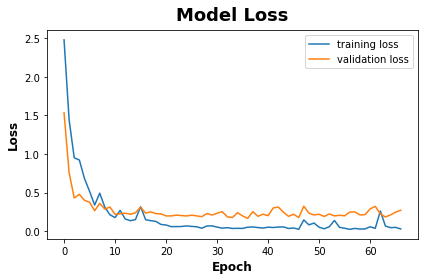

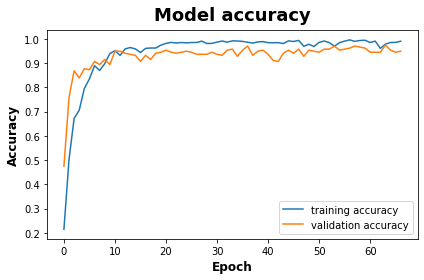

In [10]:
# Make a pandas dataframe so plots can be made from the model
history_frame = pd.DataFrame(history.history)

# Loss curve
history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'validation loss'])
plt.show()

# Accuracy curve
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()

#### The curves
At the start of the training the validation accuracy improves faster than the training accuracy. The validation set is very small so a small difference in training weights can create a huge difference in validation accuracy. After about 8 epochs the training and validation curves increase and decrease very similar to each other. We can see from the loss and accuracy curves that the training and validation data stay this close to each other for about 15 epochs. After 15 epochs the model is converging. The training loss is going down further, while the validation loss stays about the same. The same process can be observed from the accuracy curves, where the accuracy of training data is increasing, while the accuracy of the validation data stays about the same. Somewhere around this point, the model stops learning signal and starts learning noise. The code for the plots was adapted from stackoverflow ("Keras - Plot training, validation and test set accuracy," n.d.).

Now let's take a look at the model we selected, the model with the lowest validation loss, and see what its metrics are.

In [11]:
# metrics of the selected model
history_frame[history_frame.val_loss == history_frame.val_loss.min()]

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
36,0.052577,0.986054,0.16644,0.970339


#### The selected model
The selected model is a little different every time the code is ran. However, the validation accuracy is always around 95%, sometimes a little lower and sometimes a little higher. This shows great promise for the model. Based on this accuracy, we expect the model to do very well on the testset. Before we look at the testset we check whether there were any patterns within the prediction of the model by looking at the confusion matrix of the training data. The code for the confusion matrix was adapted from stackoverflow (Scikit-learn, n.d). 

['bb = black Bishop', 'bk = black King', 'bn = black Knight', 'bp = black Pawn', 'bq = black Queen', 'br = black Rook', 'emp = Empty', 'wb = white Bishop', 'wk = white King', 'wn = white Knight', 'wp = white Pawn', 'wq = white Queen', 'wr = white Rook']


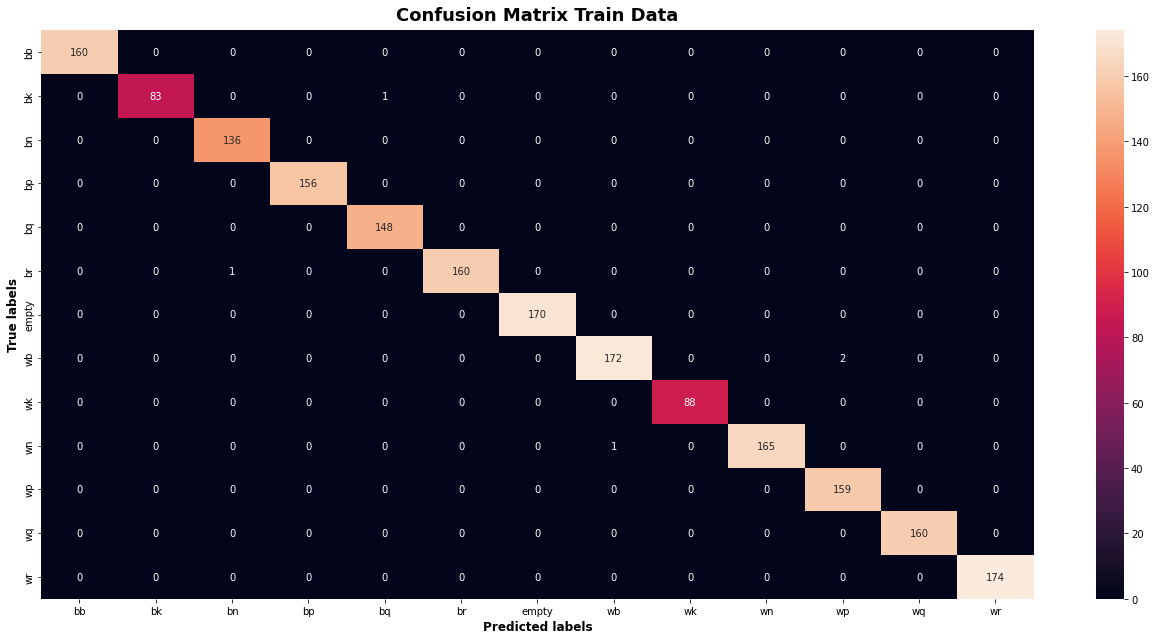

In [23]:
# Get the labels from the training data
array_train = get_labels_from_tfdataset(ds_train)
# Get the class probabilities from the model prediction on the training data
y_pred_train_prob = model.predict(ds_train)
# Use the class probabilities from the model prediction to get class predictions
y_pred_train = np.argmax(y_pred_train_prob,axis=1)

# Get the true values of the training data
y_true_train = np.argmax(array_train,axis=1)

# Create a confusion matrix of the true classes compared to the predicted classes
cm_train = confusion_matrix(y_pred_train, y_true_train)

# now we plot the confusion matrix for the training data
plt.figure(figsize=(18,9))
ax_train = plt.subplot()
# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax_train);  

# labels, title and ticks
ax_train.set_xlabel('Predicted labels');
ax_train.set_ylabel('True labels'); 
ax_train.set_title('Confusion Matrix Train Data');
ax_train.xaxis.set_ticklabels(['bb', 'bk', "bn", "bp", "bq", "br", "empty", "wb", "wk", "wn", "wp", "wq", "wr"]);
ax_train.yaxis.set_ticklabels(['bb', 'bk', "bn", "bp", "bq", "br", "empty", "wb", "wk", "wn", "wp", "wq", "wr"]);

# This serves as a legend which is too big for the plot
print(['bb = black Bishop', 'bk = black King', "bn = black Knight",
                "bp = black Pawn", "bq = black Queen", "br = black Rook",
                "emp = Empty", "wb = white Bishop", "wk = white King",
                "wn = white Knight","wp = white Pawn", "wq = white Queen",
                "wr = white Rook"])

#### Class Accuracy
Almost all predictions on the trainingset were correct. There is no pattern observed in any specific prediction for a class of pieces. We expect the model to predict the class of pieces accurately in the testset. Furthermore, we expect there to be no particular patterns with wrong predictions.

## 7. Model Performance on the Test Set

In the following, we will use our trained model on a new data set it has not seen before: the test data. We first get the predicted values for the "test data" from our model with the model.predict function. Model.predict returns 13 probabilities for each picture (that is the outcome of the Softmax function). We choose the category with the highest probability which provides us with the predicted test classes. We compare the predicted classes with the true classes in a confusion matrix to see how well our model could predict the classes of the test data. To look more closely at the different class predictions, we also take a look at the classification report of the model.

['bb = black Bishop', 'bk = black King', 'bn = black Knight', 'bp = black Pawn', 'bq = black Queen', 'br = black Rook', 'emp = Empty', 'wb = white Bishop', 'wk = white King', 'wn = white Knight', 'wp = white Pawn', 'wq = white Queen', 'wr = white Rook']


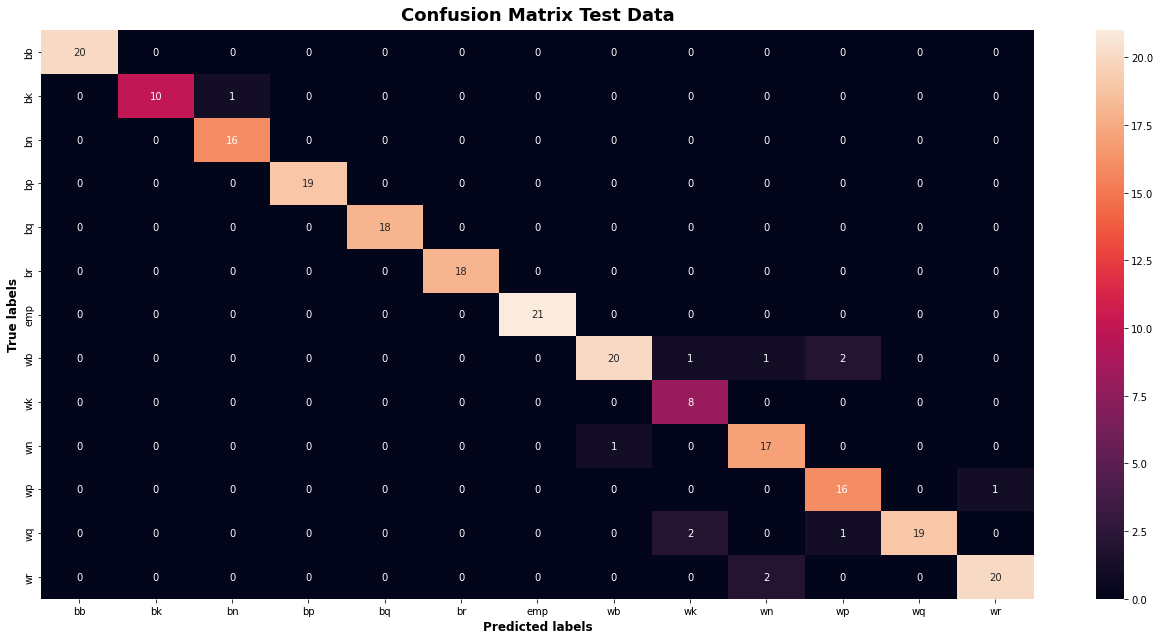

In [13]:
# Get the labels from the test data
array_test = get_labels_from_tfdataset(ds_test)
# Get the class probabilities from the model prediction on the test data
y_pred_test_prob = model.predict(ds_test)
# Use the class probabilities from the model prediction to get class predictions
y_pred_test = np.argmax(y_pred_test_prob, axis=1)

# Get the true values of the training data
y_true_test = np.argmax(array_test,axis=1)

# Create a confusion matrix of the true classes compared to the predicted classes
cm_test = confusion_matrix(y_pred_test, y_true_test)

# now we plot the confusion matrix for the test data
plt.figure(figsize=(18,9))
ax_test = plt.subplot()
# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax_test);

# labels, title and ticks
ax_test.set_xlabel('Predicted labels');
ax_test.set_ylabel('True labels'); 
ax_test.set_title('Confusion Matrix Test Data');
ax_test.xaxis.set_ticklabels(['bb', 'bk', "bn", "bp", "bq", "br", "emp", "wb", "wk", "wn", "wp", "wq", "wr"]);
ax_test.yaxis.set_ticklabels(['bb', 'bk', "bn", "bp", "bq", "br", "emp", "wb", "wk", "wn", "wp", "wq", "wr"]);


# This serves as a legend which is too big for the plot
print(['bb = black Bishop', 'bk = black King', "bn = black Knight",
                "bp = black Pawn", "bq = black Queen", "br = black Rook",
                "emp = Empty", "wb = white Bishop", "wk = white King",
                "wn = white Knight","wp = white Pawn", "wq = white Queen",
                "wr = white Rook"])


### 7.1  Confusion Matrix

We create a confusion matrix of the model with the confusion_matrix function. Due to aestetic reasons we did not plot the full names of each category or figure as this did not fit on the axes. Instead, a print statement with the proper labels is added.

It can be seen from the confusion matrix that the model performs very well on the test data. Almost all predictions on the test data were correct with only a few cases misspecified. It seems that more incorrect predictions are located on the right side of the plot which resembles white pieces. Even though there are not enough images misspecified to call this a clear pattern, it is still an interesting observation. One potential explanation could be that light reflections of the white board led to inconsistencies with white pieces and less with black pieces. However, first a testset with more data should be used to re-evaluate if this "pattern" appears consistenly within the data.

In [14]:
# Creating a list of all the possible classes
target_names = ['black Bishop', 'black King', "black Knight",
                "black Pawn", "black Queen", "black Rook",
                "Empty", " white Bishop", "white King",
                "white Knight","white Pawn", "white Queen",
                "white Rook"]

# Making a classifcation report on the test data
print(classification_report(y_pred_test, y_true_test, target_names = target_names, digits = 4))
# Printing the overall accuracy of the model on the test data
print("total accuracy",accuracy_score(y_pred_test, y_true_test))

               precision    recall  f1-score   support

 black Bishop     1.0000    1.0000    1.0000        20
   black King     1.0000    0.9091    0.9524        11
 black Knight     0.9412    1.0000    0.9697        16
   black Pawn     1.0000    1.0000    1.0000        19
  black Queen     1.0000    1.0000    1.0000        18
   black Rook     1.0000    1.0000    1.0000        18
        Empty     1.0000    1.0000    1.0000        21
 white Bishop     0.9524    0.8333    0.8889        24
   white King     0.7273    1.0000    0.8421         8
 white Knight     0.8500    0.9444    0.8947        18
   white Pawn     0.8421    0.9412    0.8889        17
  white Queen     1.0000    0.8636    0.9268        22
   white Rook     0.9524    0.9091    0.9302        22

     accuracy                         0.9487       234
    macro avg     0.9435    0.9539    0.9457       234
 weighted avg     0.9543    0.9487    0.9493       234

total accuracy 0.9487179487179487



### 7.2 Classification Report 

The model performed very well on the test data. However, we are still interested to see where the model is actually lacking. Which classes contain more false positives and which classes contain more false negatives? To answer this question we use the classification_report function, to see how the model made most of its classification mistakes. From the classification report we can see how exactly our model performed on the test data. 

- Precision gives an indication about how the network performed. It is defined as the ratio of true positives (classifying a piece correctly) divided by the sum of true and false positives ("Understanding the classification report through sklearn," n.d.). It can be seen that white pieces are classified with less precision compared to black pieces. The precision of the model overall is very good.  
- Recall is definded as the propostion of true positives divided by the sum of true positives and false negatives (not detecting a specific piece correctly) ("Understanding the classification report through sklearn," n.d.). The recall of the model overall is very good with no specific differences between pieces.
- The F1 scores are the harmonic means between recall and precision such that the best score is 1.0 and the worst is 0.0 ("Understanding the classification report through sklearn," n.d.). Most scores are above .95, with a little lower scores for white pieces compared to black pieces. The F1 scores of the model overall is very good.

On average, the model performs very well on all these metrices. The question arises why the model classifies black pieces a little more precise than white pieces. We did not see the imbalance of white and black pieces in the training set. A larger testset is needed to check whether this pattern is consistent with our chosen model.

The total accuracy is a little different every time the code is ran. However, the test accuracy is always around 95%, sometimes a little lower and sometimes a little higher. This is very similar to the accuracy of the validation set, which is exactly why this was used for training. A very high accuracy on the test data shows that training has done a good job of learning signal without learning too much noise. 

## 8. Application: How does the model perform on a different real life chess set?

At this stage, we were satisfied with our parameter tuning and how well our model performed. Our end goal was to produce a neural network that could classify chess pieces in the real world, so to see how close we were to this goal, we looked to see how well our network would perform on images of a different chess set.  

We begun collecting data ourselves. We took 120 photographs across 2 different chess sets. There were 60 photos per board, 30 pictures of black pieces and 30 of white pieces, resulting in 5 pictures per type of chess piece.

Below you can see an example of our application dataset compared to the dataset the model was trained on. On the left are images from the original dataset, in the middle are images from the first application board and on the right are images from the second application board. Notable differences between the two datasets are the following: 
1. the pieces in the new dataset are all the same, only the boards differ 
2. the board colours are different 
3. the specific shapes of the pieces vary quite a lot between the new and original data 
4. the quality of images in the new dataset is much higher

In [ ]:
Image(filename="../input/different-boards/different chess boards.jpeg", width = 400)

### 8.1 Loading in the Application Data

Just like we did with the other datasets in the notebook, we load in our data with the image_dataset_from_directory function and normalize our images with the convert_to_float function.

In [ ]:
# Load in the application data
ds_application = image_dataset_from_directory(
   '../input/dataapplication/Application_data',
    labels='inferred',         # same labels as map labels
    label_mode='categorical',  # categorical data
    image_size=[224, 224],
    interpolation='nearest',   # used for small image size
    batch_size=32,
    shuffle=True,              # classes are randomized
)

# Normalize images from the application data
AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_application = (
    ds_application
   .map(convert_to_float)
   .cache()
   .prefetch(buffer_size=AUTOTUNE)
)

### 8.2 Model Performance on Application Data

Just like with the test data, we can now take a look at the model perfomance on these application data by looking at the confusion matrix and the classification report.

#### Confusion Matrix

In [ ]:
# Get the labels from the application data
array_application = get_labels_from_tfdataset(ds_application)
# Get the class probabilities from the model prediction on the application data
y_pred_application_prob = model.predict(ds_application)
# Use the class probabilities from the model prediction to get class predictions
y_pred_application = np.argmax(y_pred_application_prob, axis=1)

# Get the true values of the application data
y_true_application = np.argmax(array_application,axis=1)

# Create a confusion matrix of the true classes compared to the predicted classes
cm = confusion_matrix(y_pred_application, y_true_application)

# Now we plot the confusion matrix for the application data
plt.figure(figsize=(15,7.5))
ax_application = plt.subplot()
# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cm, annot=True, fmt='g', ax=ax_application);

# labels, title and ticks
ax_application.set_xlabel('Predicted labels');
ax_application.set_ylabel('True labels'); 
ax_application.set_title('Confusion Matrix Application Data');
ax_application.xaxis.set_ticklabels(['bb', 'bk', "bn", "bp", "bq", "br", "empty", "wb", "wk", "wn", "wp", "wq", "wr"]);
ax_application.yaxis.set_ticklabels(['bb', 'bk', "bn", "bp", "bq", "br", "empty", "wb", "wk", "wn", "wp", "wq", "wr"]);

#### Classification Report 

In [ ]:
# Creating a list of all the possible classes
target_names = ['bb', 'bk', "bn", "bp", "bq", "br", "empty", "wb", "wk", "wn", "wp", "wq", "wr"]
# Making a classifcation report on the application data
print(classification_report(y_pred_application, y_true_application, target_names=target_names, digits=4))

# Printing the overall accuracy of the model on the application data
print("total accuracy",accuracy_score(y_pred_application, y_true_application))

#### Evaluation

It can easily be detected that the trained model did a poor job on the application data set. The confusion matrix shows very bad predictions for the specific classes. It looks like the model could not find the right classes and instead guessed a lot of the same classes multiple times throughout its prediction, while not guessing certain other classes at all. For instance the black queen was never predicted by the model, while an empty board was predicted a lot by the model.

The classification report reaffirms what the confusion matrix indicates. The model did a poor job on the application data set. For a lot of pieces the precision is 0, which means that none of the pieces were correctly identified. About half of the classes have an F1 score of 0 which means a very bad relation between recall and precision.  

The total accuracy is a little different every time the code is ran. However, the overall application accuracy is always around 25%, sometimes a little lower and sometimes a little higher. Therefore we can conclude that the model did not generalise well with respect to our own chess boards. We can conclude that we are not yet at the goal of using this model in the real world. We would have to train a model that is more robust against background changes and possibly also little changes in pieces. The next step would be to include pictures from different chess sets and chess boards to increase generalisability of the trained model.

# Conclusion

We started out this project with the idea of creating a model that could transform a real life chess board position into a FEN description. By putting the FEN description into a computer program, a real life chess game could be played out online. This project focussed on the first stage of creating such a model: a convolutional neural network that could identify the different chess pieces.

#### Summary Results
A model was trained on a dataset of 1936 images of chess pieces from the same chess set. The final model was selected using validation loss and had a validation accuracy of about 95%. No specific patterns in wrong predictions could be identified from the training classification. 
<br> The trained model performed very well on the testset, with a similar accuracy as the validation set: about 95%. Looking at missclassified pieces there were a little more wrong predictions for white pieces compared to black pieces, but the test set was too small to confirm a consistent pattern.
<br> To see how close the model was to be used in the real world, we collected our own dataset with a different chess set. The model did not generalize well on the  chess application data with only about 25% prediction accuracy.  

#### Final Notes
Overall we think that the training of the model on this dataset was a succes. We were able to create a model that could very accurately identify different chess pieces on similar chess boards. Underwood (2020) did not give an overall accuracy of his model. After replicating his exact model and looking at his reported confusion matrix we found that Underwood could get a model with an accuracy of about 89-91%. So we improved his model by 4-6%! It is also important to note that Underwood uses only 10 epochs to combat overfitting, while we use a validation set and early stopping to combat overfitting. Our model is therefore a bit more consistent and stable in the selection of the final model. 

The only problem with the model is that it did not generalize well to data from different types of chess boards. The dataset was not variable enough to account for differences in chess sets. This is something we we have to account for in further research by incorporating images of different chess boards in our training process.   

After this process is repeated with a more all around dataset, we can move on to the next stage and create a network that can identify the different squares of the chess board. In this way we can combine the networks to create a model that can create a FEN description from a picture of a real life chess board position. The FEN description could be loaded into a computer and a real life chess game could be played out online. A handy tool in these times of the corona virus, where we are constantly switching between real life contact and contact online.

### References 


*Automatic localization of casting defects with convolutional neural networks.* (n.d). ResearchGate. Retrieved December 7, 2021, from .https://www.researchgate.net/figure/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only_fig3_322512435 

Cook, A., Holbrook, R. (n.d.). *The Convolutional Classifier.* Kaggle. Retrieved December 10, 2021, from https://www.kaggle.com/ryanholbrook/the-convolutional-classifier

*Code faster with line-of-code completions, cloudless processing.* (n.d.). Kite - Free AI Coding Assistant and Code Auto-Complete Plugin. https://www.kite.com/python/answers/how-to-count-frequency-of-unique-values-in-a-numpy-array-in-python

*Extract target from TensorFlow PrefetchDataset.* (n.d). Stack Overflow. Retrieved December 7, 2021, from https://stackoverflow.com/questions/62436302/extract-target-from-tensorflow-prefetchdataset 

Hunter, G., Dale, D., Firing, E., Droettboom, M. (n.d.) *Interpolations for imshow.* Matplotlib. Retrieved December 17, 2021, from https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html

James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). *An Introduction to Statistical Learning*, (Vol. 112, p. 18). New York: springer.

*Keras -Plot training, validation and test set accuracy*. (n.d). Stack Overflow. Retrieved December 7, 2021, from https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

Koryakin, P. *Chess Positions: Recognise chess position of 5-15 pieces*, [Data set], Retrieved December 7, 2021, from https://www.kaggle.com/koryakinp/chess-positions

Mitchell, J. *Chess Game Dataset (Lichess).*  (n.d).  Kaggle. [Data set],  Retrieved December 4, 2021, from https://www.kaggle.com/datasnaek/chess
Muthukrishnan – AI, Computer Vision and Mathematics. (2018, July 7)  

*Understanding the classification report through sklearn*, https://muthu.co/understanding-the-classification-report-in-sklearn/
Nunn, J. (2021, January 28). *Chess Under Covid*, Chess Base. https://en.chessbase.com/post/chess-under-covid

Sandro, S. (2018). *Introduction to Deep Learning — From Logical Calculus to Artificial Intelligence*. Cham, Switzerland: Springer. ISSN 1863-7310, ISSN 2197-1781. https://doi.org/10.1007/978-3-319-73004-2

*Scikit learn output metrics.classification_report into CSV/tab-delimited format.* (n.d). Stack Overflow. Retrieved December 20, 2021, from https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format

Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. https://arxiv.org/abs/1409.1556

*Sklearn plot confusion matrix with labels.* (n.d.). Stack Overflow. Retrieved December 20, 2021, from https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

*Sklearn.metrics.confusion_matrix*. (n.d.). scikit-learn. Retrieved December 20, 2021, from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

Stewart, M. (2019, July 9). Simple Guide to Hyperparameter Tuning in Neural Networks, *Towards Data Science*. https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594

Underwood, A. (2020, October 21). Board Game Image Recognition using Neural Networks, *Towards Data Science*  https://towardsdatascience.com/board-game-image-recognition-using-neural-networks-116fc876dafa

